# Scrape av historiska pdf-filer

In [1]:
#!pip install tabula
#!java -version
import tabula 

In [2]:
from IPython.display import display
import pandas as pd 
import numpy as np
import pickle

with open('pickle/summa_rapporter.pkl', 'rb') as f:
    SUMMA_RAPPORTER = pickle.load(f)
    
with open('pickle/summa_handlagda.pkl', 'rb') as f:
    SUMMA_HANDLAGDA = pickle.load(f)
    
with open('pickle/okänd_spruta.pkl', 'rb') as f:
    OKÄND_SPRUTA = pickle.load(f)

with open('pickle/summa_allvarliga.pkl','rb') as f:
    SUMMA_ALLVARLIGA = pickle.load(f)


SUMMA_RAPPORTER,SUMMA_HANDLAGDA,OKÄND_SPRUTA,SUMMA_ALLVARLIGA

(101867, 24753, 438, 10336)

## Funktioner för att gräva ut tabeller

In [3]:
# create a list 


def antal_döda(pdf_fil, ix):
       
       döda = pdf_fil[ix].loc[:,'Totalt'].astype(int).to_list()
       return döda

def antal_allvarliga(pdf_astra,pdf_pfizer,pdf_moderna):
       ixa = 2
       ixp = 2
       ixm = 2
       kolumner = ['Ej allvarliga', 'Allvarliga']
       astra = pdf_astra[ixa].drop('Totalt',axis=1).copy()
       astra.columns=['Astra'] + kolumner
       astra['Ej allvarliga'] = astra['Ej allvarliga'].str.replace(',','').astype(int)
       astra['Allvarliga'] = astra['Allvarliga'].str.replace(',','').astype(int)
       astra['Totalt'] = astra['Ej allvarliga'] + astra.Allvarliga
       
       moderna = pdf_moderna[ixm].drop('Totalt',axis=1).copy()
       moderna.columns=['Moderna'] + kolumner
       moderna['Totalt'] = moderna['Ej allvarliga'] + moderna.Allvarliga
       
       pfizer = pdf_pfizer[ixp].drop('Totalt',axis=1).copy()
       pfizer.columns=['Pfizer'] + kolumner
       pfizer['Ej allvarliga'] = pfizer['Ej allvarliga'].str.replace(',','').astype(int)
       pfizer['Allvarliga']    = pfizer['Allvarliga'].str.replace(',','').astype(int)
       pfizer['Totalt']       = pfizer['Ej allvarliga'] + pfizer.Allvarliga
      
       # moderna['Totalt']+astra['Totalt']+pfizer['Totalt']

       return (astra,pfizer,moderna)


## Ålderstabeller

In [4]:
def skapa_ålderstabell(företag,tab):
    
    kolumner = ['Allvarligt kvinnor','Allvarligt män', 'Ej allvarligt kvinnor','Ej allvarligt män']
    display(tab)
    the_tab = tab.drop('Unnamed: 0',axis=1).iloc[1:-1].copy()
    if the_tab.shape[1] == 6:
        kolumner = kolumner + ['Ej allvarligt okänt']

    the_tab.fillna('0',inplace=True)
    the_tab.columns=[företag] + kolumner
    for kol in kolumner:
        the_tab[kol] = the_tab[kol].astype(int)
    return the_tab
    
def tre_ålderstabeller(pdf_astra, pdf_pfizer, pdf_moderna):
    ixa = 3
    ixp = 3
    ixm = 3

    astra = skapa_ålderstabell('Astra',pdf_astra[ixa])
    pfizer = skapa_ålderstabell('Pfizer',pdf_pfizer[ixp])
    moderna = skapa_ålderstabell('Moderna',pdf_moderna[ixm])
    return astra,pfizer,moderna


# Dödstabeller

In [5]:
# Hitta alla pdf-filer
import pickle
import glob
pfizer_files = glob.glob('./pickle/comirnaty_pdf/**.pdf', recursive=True)
moderna_files = glob.glob('./pickle/moderna_pdf/**.pdf', recursive=True)
astra_files = glob.glob('./pickle/vaxevria_pdf/**.pdf', recursive=True)

## Pfizer/Moderna/Astra har Ålderstabeller för allvarliga fall fom 2021-09-22
ÅLDERSGRUPPER = ['10-19 år', '20-29 år', '30-39 år','40-49 år','50-59 år','60-69 år','70-79 år','80-89 år','90+','okänt']

pfizer_dat=[]
for f in pfizer_files:
    dat=f[-14:-4]
    # print(dat)
    pfizer_dat.append(dat)
if len(pfizer_dat) != len(set(pfizer_dat)):
    print('duplicates in pfizer')
print('len p',len(pfizer_dat))    
    
moderna_dat=[]    
for f in moderna_files:
    dat=f[-14:-4]
    moderna_dat.append(dat)
    if dat not in pfizer_dat:
        print(dat, 'in moderna not in pfizer')
if len(moderna_dat) != len(set(moderna_dat)):
        print('duplicates in moderna')
print('len m',len(moderna_dat))

astra_dat=[]    
for f in astra_files:
    dat=f[-14:-4]
    astra_dat.append(dat)
    if dat not in pfizer_dat:
        print(dat, 'in astra not in pfizer')
    if dat not in moderna_dat:
        print(dat, 'in astra not in moderna')
if len(astra_dat) != len(set(astra_dat)):
    print('duplicates in astra')
print('len a',len(astra_dat))
    
for d in pfizer_dat:
    if d not in moderna_dat:
        print(d, 'in pfizer not in moderna')
    if d not in astra_dat:
        print(d, 'in pfizer not in astra')
    
for d in moderna_dat:
    if d not in astra_dat:
        print(d, 'in moderna not in astra')
        

len p 52
len m 52
len a 52


## Nyttiga funktioner

In [6]:
# läs in dicts för alla tre företagen
def load_dicts(pfizer,moderna,astra):
    pfizer_dict,moderna_dict,astra_dict = None,None,None
    if pfizer:
        with open('pickle/pfizer_dict.pkl','rb') as f:
            pfizer_dict = pickle.load(f)  
            
    if moderna:
        with open('pickle/moderna_dict.pkl','rb') as f:
            moderna_dict = pickle.load(f) 
    
    if astra:
        with open('pickle/astra_dict.pkl','rb') as f:
            astra_dict = pickle.load(f) 
    
    return pfizer_dict,moderna_dict,astra_dict   
pfizer_dict, moderna_dict, astra_dict = load_dicts(True,True,True) 

def spara_dict(pfizer_dict,moderna_dict,astra_dict):
    
    with open('pickle/pfizer_dict.pkl','wb') as f:
        pfizer_dict = dict(sorted(pfizer_dict.items(), key=lambda x: x[0]))
        pickle.dump(pfizer_dict, f)
    
    with open('pickle/moderna_dict.pkl','wb') as f:
        moderna_dict = dict(sorted(moderna_dict.items(), key=lambda x: x[0]))
        pickle.dump( moderna_dict, f)
    
    with open('pickle/astra_dict.pkl','wb') as f:
        astra_dict = dict(sorted(astra_dict.items(), key=lambda x: x[0]))
        pickle.dump(astra_dict, f)
 
def ny_dict_rad(datum):
        # default kopiera föregående
    pfizer_dict,moderna_dict,astra_dict = load_dicts(True,True,True )
    
    last=list(pfizer_dict)[-1]
    pfizer_dict[datum] = pfizer_dict[last] 

    last=list(moderna_dict)[-1]
    moderna_dict[datum] = moderna_dict[last] 

    last=list(astra_dict)[-1]
    astra_dict[datum] = astra_dict[last] 
    
    spara_dict(pfizer_dict, moderna_dict, astra_dict)
                  
# läs in dicts för alla tre företagen
def load_döda(pfizer,moderna,astra):
    pfizer_döda,moderna_döda,astra_döda = None,None,None
    if pfizer:
        with open('pickle/pfizer_döda.pkl','rb') as f:
            pfizer_döda = pickle.load(f)  
            
    if moderna:
        with open('pickle/moderna_döda.pkl','rb') as f:
            moderna_döda = pickle.load(f) 
    
    if astra:
        with open('pickle/astra_döda.pkl','rb') as f:
            astra_döda = pickle.load(f) 
    
    return pfizer_döda,moderna_döda,astra_döda  

def spara_döda(pfizer, moderna, astra) :
    if pfizer:
        with open('pickle/pfizer_döda.pkl','wb') as f:
            pickle.dump(pfizer_döda, f)
    if moderna:        
        with open('pickle/moderna_döda.pkl','wb') as f:
            pickle.dump(moderna_döda, f)
    if astra:    
        with open('pickle/astra_döda.pkl','wb') as f:
            pickle.dump(astra_döda, f)

def fyll_i_datum_med_saknade_kön(döda_, företag):
    ## I början fanns inte kön angivet. Låt dessa datum få man och kvinna nan-ifyllda
    ## Låt senare datum få 'okänt kön' nan-ifyllt
    ## Allt för att kunna få ut grafer
    döda = döda_.copy()
    my_dict=dict()
    
    for d in döda[döda.Kön=='kvinnor'].Datum:
            my_dict = {'Datum':d, 'Kön': 'o', '10-19 år':None, '20-29 år':None, '30-39 år':None, '40-49 år':None,'50-59 år':None, 
                       '60-69 år':None, '70-79 år':None, '80-89 år':None, '90+':None, 'okänt':None, 'Företag':företag,'Total':None}
            döda = döda.append(my_dict,ignore_index=True)
    
    for d in döda[döda.Kön=='okänt kön'].Datum:
        my_dict = {'Datum':d, 'Kön': 'kvinnor',  '10-19 år':None, '20-29 år':None, '30-39 år':None, '40-49 år':None,'50-59 år':None, 
                       '60-69 år':None, '70-79 år':None, '80-89 år':None, '90+':None, 'okänt':None, 'Företag':företag,'Total':None}
        döda = döda.append(my_dict,ignore_index=True)
        my_dict = {'Datum':d, 'Kön': 'män',  '10-19 år':None, '20-29 år':None, '30-39 år':None, '40-49 år':None,'50-59 år':None, 
                       '60-69 år':None, '70-79 år':None, '80-89 år':None, '90+':None, 'okänt':None, 'Företag':företag,'Total':None}
        döda = döda.append(my_dict,ignore_index=True)
        
    döda.loc[döda.Kön=='o','Kön']='okänt kön'
    döda.sort_values(by=['Datum','Kön'],inplace=True)
    
    return döda      

pfizer_döda,moderna_döda,astra_döda = load_döda(True,True,True)
pfizer_döda = fyll_i_datum_med_saknade_kön(pfizer_döda,'Pfizer')
astra_döda = fyll_i_datum_med_saknade_kön(astra_döda,'Astra')
moderna_döda = fyll_i_datum_med_saknade_kön(moderna_döda,'Moderna')
spara_döda(True,True,True)
                       
 

## Scraping-funktioner

In [7]:
             
def vilka_åldrar_finns(tab):
    åldersgrupper = ÅLDERSGRUPPER.copy()
    if tab.columns[1] == 'Unnamed: 0':  # finns ej i kolumnnamn? sök 1:a rad
        tab_åldrar= tab.iloc[0,1:].to_list()
        display('i 1:a raden')
    else:  # sök i kolumn-namnen
        tab_åldrar = tab.columns[1:]
        display('i kolnamn')
        
    tab_åldrar = ['Un' if x != x else x for x in tab_åldrar]
    # display(tab_åldrar, type(tab_åldrar))
    tab_åldrar=[x[:2] for x in tab_åldrar]
        
    åldersgrupper = list(filter(lambda x: x[:2] in tab_åldrar,åldersgrupper))
    if 'Un' in tab_åldrar:
        åldersgrupper = åldersgrupper+['90+','okänt']
        
    print('tab-åldrar',tab_åldrar,'åldersgrupper',åldersgrupper)
    return åldersgrupper

def hantera_döda_ej_kön(df_döda, tab, datum, företag):
    tab = tab.iloc[:,:-1]
    ålders_dict = dict.fromkeys(['Kön']+ÅLDERSGRUPPER,[0] )
    åldersgrupper=vilka_åldrar_finns(tab)   
    
    print('åldersgrupper',åldersgrupper)    
    display('tab',tab)
    # tab.columns=['Kön']+åldersgrupper

    for kol in tab.columns[1:]:
        if np.isnan(tab.loc[0,kol]):
            ålders_dict.update({kol:[int(tab.loc[1,kol])],'Kön':['okänt kön']})
        else:
            ålders_dict.update({kol:[int(tab.loc[0,kol])],'Kön':['okänt kön']})
     
    df = pd.DataFrame.from_dict(ålders_dict,orient='columns')  
    
    df['Företag'] = företag 
    df['Datum'] = datum
    df = df[['Datum']+list(df.columns[:-1])] 
    df= pd.concat([df_döda.copy(),df])
    return df

def hantera_döda_med_kön(df_döda, tab, datum, företag):
    # utgår från att tabellen har aåldersgrupp '10-19' och uppåt samt
    # samt att tabellens sista kolumner är 'okänd ålder' och Total
    tab = tab.iloc[:-1,:-1].copy()
    
    ålders_dict = dict.fromkeys(['Kön']+ÅLDERSGRUPPER,[0,0] )
    åldersgrupper=vilka_åldrar_finns(tab)   
    # print('åldersgrupper',åldersgrupper)
        
    tab.columns=['Kön']+åldersgrupper

    tab = tab[(tab.iloc[:,0]=='Kvinna') | (tab.iloc[:,0]=='Man') ].fillna(0)
    display(tab)
    
    for kol in tab.columns:
        kvinnor = tab[kol].iloc[0]
        män = tab[kol].iloc[1]
        ålders_dict.update({kol:[kvinnor,män],'Kön':['kvinnor','män']})
    
    df=pd.DataFrame(ålders_dict)
    df['Företag']=företag
    df['Datum']= datum
    df = df[['Datum']+list(df.columns)[:-1]]
    
    df= pd.concat([df_döda.copy(),df])

    return df 

# ta bort dubletter av Datum, Kön
def remove_duplicates(df_):
    df = df_.copy()
    
    df = df.drop_duplicates(subset=['Datum','Kön'])
    df.sort_values(by=['Datum','Kön'],inplace=True)
    df.reset_index(drop=True,inplace=True)
    return df



## Ta reda på senaste datum

In [8]:
# sort files to get the latest
pfizer_dict, moderna_dict, astra_dict = load_dicts(True,True,True)

pfizer_files.sort(key=lambda x: x[-14:-4])
moderna_files.sort(key=lambda x: x[-14:-4])
astra_files.sort(key=lambda x: x[-14:-4])
pfizer_sista = pfizer_files[-1][-14:-4]
moderna_sista = moderna_files[-1][-14:-4]
astra_sista = astra_files[-1][-14:-4]

sista_datum = pfizer_sista
print(f'sista datum i files: {sista_datum}',pfizer_sista==moderna_sista and pfizer_sista==astra_sista and moderna_sista==astra_sista)

if max(pfizer_dict.keys()) == sista_datum and max(moderna_dict.keys()) == sista_datum and max(astra_dict.keys()) == sista_datum:
    print('alla dict är redan uppdaterade')
else:
    print('uppdatera dict med',sista_datum)
    # add sista datum to dict with a copy from the latest key
    pfizer_dict.update({sista_datum:pfizer_dict[max(pfizer_dict.keys())].copy()})
    moderna_dict.update({sista_datum:moderna_dict[max(moderna_dict.keys())].copy()})
    astra_dict.update({sista_datum:astra_dict[max(astra_dict.keys())].copy()})


antal_handlagda = pd.read_csv('pickle/antal_handlagda_bas.csv')
# add row with sista_datum if it doesn't exist
if sista_datum not in antal_handlagda['date'].values:
    import datetime
    ej_handlagda = SUMMA_RAPPORTER-SUMMA_HANDLAGDA
    handlagt_procent = int(round((SUMMA_HANDLAGDA/SUMMA_RAPPORTER)*100))
    # get week number
    week_number = datetime.datetime.strptime(sista_datum, '%Y-%m-%d').isocalendar()[1]
    print('OKÄND_SPRUTA',OKÄND_SPRUTA)
    # display(antal_handlagda)
    antal_handlagda = antal_handlagda.append(pd.DataFrame({'date':sista_datum,
                                                           'week':week_number,
                                                           'handlagt':handlagt_procent,
                                                           'Ej handlagda':ej_handlagda, 
                                                           'Handlagda':SUMMA_HANDLAGDA,
                                                           'okänd_spruta':int(OKÄND_SPRUTA),
                                                           'Allvarliga':int(SUMMA_ALLVARLIGA),
                                                           },index=[len(antal_handlagda)]))
    
    antal_handlagda.loc[antal_handlagda['date']==sista_datum,'Handlagda'] = SUMMA_HANDLAGDA
    antal_handlagda.to_csv('pickle/antal_handlagda_bas.csv',index=False)
    display(antal_handlagda)

if input(f'{sista_datum}  SPARA DICTS? (y/n + Enter)') == 'y':
    print('yes')
    spara_dict(pfizer_dict, moderna_dict, astra_dict)
else:
    print('no')


sista datum i files: 2022-03-23 True
uppdatera dict med 2022-03-23
OKÄND_SPRUTA 438


,date,week,handlagt,Ej handlagda,Handlagda,okänd_spruta,Allvarliga
0,2021-03-03,9,19,6151,1443,NaN,556
1,2021-03-10,10,14,11152,1816,NaN,695
2,2021-03-17,11,12,16127,2199,NaN,820
3,2021-03-24,12,12,17722,2417,NaN,929
4,2021-03-31,13,12,18647,2543,NaN,1158
5,2021-04-07,14,13,19189,2867,NaN,1295
6,2021-04-14,15,12,21052,2871,NaN,1420
7,2021-04-21,16,12,22915,3125,NaN,1565
8,2021-04-28,17,12,25345,3456,NaN,1728
9,2021-05-05,18,12,27439,3742,NaN,2007


yes


In [9]:
print(SUMMA_HANDLAGDA)


24753


## Själva loopen över pdf-filer
## obs fyll i sista datum dict item

In [10]:
def find_ix_in_pdf(pdf, word):
    # print(range(0,len(pdf)))
    for i in range(0, len(pdf)):
        # print(i)
        tab = list(pdf[i].columns)
        tab = [x.replace('\r', ' ') for x in tab]
        tab_str = ''.join(tab)
        if word in tab_str:
            print('Found word', word, 'in pdf', i)
            return pdf[i], i

    return 'Error', -1000


def handle_all_files(files, the_dict,företag):
    df = pd.DataFrame(columns=['Datum','Kön'] + ÅLDERSGRUPPER)
    df[ÅLDERSGRUPPER] = df[ÅLDERSGRUPPER].astype(int)
    # df=df_.copy()
    for f_ix,file in enumerate(files[:]):

        datum =file[-14:-4]
        
        print(företag,datum)
        my_pdf = tabula.read_pdf(file, pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 

        # print('the_dict',the_dict[datum])
        # if the_dict[datum]['tab_ix'] == ' ':
        #     continue
        _, ix = find_ix_in_pdf(my_pdf, 'Dödsfall')
        if the_dict[datum]['med_kön']==False:
            # ix = the_dict[datum]['tab_ix']   # ANVÄNDS INTE LÄNGRE
            df = hantera_döda_ej_kön(df, my_pdf[ix], datum,företag)
        else:
            # ix = the_dict[datum]['tab_ix']    # ANVÄNDS INTE LÄNGRE
            df = hantera_döda_med_kön(df, my_pdf[ix], datum,företag)
       
        display(df.tail(2))
        
    numeriska = df.columns[2:-1]
    df[numeriska] = df[numeriska].astype(int)
    df.sort_values(by=['Datum','Kön'],inplace=True)
    df.reset_index(drop=True,inplace=True)

    return df

  
pfizer_dict,moderna_dict,astra_dict = load_dicts(True, True, True)
  
addera_till_senaste = True

if addera_till_senaste:  # läs in senaste filerna per företag
    pfizer_döda, moderna_döda, astra_döda = load_döda(True, True, True)
    df_pfizer = handle_all_files([pfizer_files[-1]], pfizer_dict, 'Pfizer')
    pfizer_döda = pd.concat([pfizer_döda,df_pfizer])
    df_moderna = handle_all_files([moderna_files[-1]], moderna_dict, 'Moderna')
    moderna_döda = pd.concat([moderna_döda,df_moderna])
    df_astra = handle_all_files([astra_files[-1]], astra_dict, 'Astra')
    astra_döda = pd.concat([astra_döda,df_astra])
else:
    # läs in allt
    pfizer_döda = handle_all_files(pfizer_files, pfizer_dict, 'Pfizer')
    moderna_döda = handle_all_files(moderna_files, moderna_dict, 'Moderna')
    astra_döda = handle_all_files(astra_files, astra_dict, 'Astra')

pfizer_döda = remove_duplicates(fyll_i_datum_med_saknade_kön(pfizer_döda,'Pfizer'))
moderna_döda = remove_duplicates(fyll_i_datum_med_saknade_kön(moderna_döda,'Moderna'))
astra_döda = remove_duplicates(fyll_i_datum_med_saknade_kön(astra_döda,'Astra'))

spara_döda(True,True,True)


Pfizer 2022-03-23
Found word Dödsfall in pdf 5


'i kolnamn'

tab-åldrar ['10', '20', '30', '40', '50', '60', '70', '80', '90', 'ok'] åldersgrupper ['10-19 år', '20-29 år', '30-39 år', '40-49 år', '50-59 år', '60-69 år', '70-79 år', '80-89 år', '90+', 'okänt']


,Kön,10-19 år,20-29 år,30-39 år,40-49 år,50-59 år,60-69 år,70-79 år,80-89 år,90+,okänt
0,Kvinna,1.0,0.0,1.0,3.0,3.0,15.0,29.0,61.0,47.0,0.0
1,Man,1.0,1.0,1.0,3.0,7.0,16.0,39.0,50.0,16.0,1.0


,Datum,Kön,10-19 år,20-29 år,30-39 år,40-49 år,50-59 år,60-69 år,70-79 år,80-89 år,90+,okänt,Företag
0,2022-03-23,kvinnor,1.0,0.0,1.0,3.0,3.0,15.0,29.0,61.0,47.0,0.0,Pfizer
1,2022-03-23,män,1.0,1.0,1.0,3.0,7.0,16.0,39.0,50.0,16.0,1.0,Pfizer


Moderna 2022-03-23
Found word Dödsfall in pdf 5


'i kolnamn'

tab-åldrar ['30', '40', '50', '60', '70', '80', '90'] åldersgrupper ['30-39 år', '40-49 år', '50-59 år', '60-69 år', '70-79 år', '80-89 år', '90+']


,Kön,30-39 år,40-49 år,50-59 år,60-69 år,70-79 år,80-89 år,90+
0,Kvinna,0.0,0.0,0.0,4,6,4,3
1,Man,2.0,2.0,1.0,4,10,3,2


,Datum,Kön,10-19 år,20-29 år,30-39 år,40-49 år,50-59 år,60-69 år,70-79 år,80-89 år,90+,okänt,Företag
0,2022-03-23,kvinnor,0,0,0.0,0.0,0.0,4,6,4,3,0,Moderna
1,2022-03-23,män,0,0,2.0,2.0,1.0,4,10,3,2,0,Moderna


Astra 2022-03-23
Found word Dödsfall in pdf 5


'i kolnamn'

tab-åldrar ['50', '60', '70', '80', '90'] åldersgrupper ['50-59 år', '60-69 år', '70-79 år', '80-89 år', '90+']


,Kön,50-59 år,60-69 år,70-79 år,80-89 år,90+
0,Kvinna,1,5,10,3,0.0
1,Man,1,5,18,3,1.0


,Datum,Kön,10-19 år,20-29 år,30-39 år,40-49 år,50-59 år,60-69 år,70-79 år,80-89 år,90+,okänt,Företag
0,2022-03-23,kvinnor,0,0,0,0,1,5,10,3,0.0,0,Astra
1,2022-03-23,män,0,0,0,0,1,5,18,3,1.0,0,Astra


In [11]:
### updatera pfizer_dict
# pfizer_dict, moderna_dict, astra_dict = load_dicts(True, True, True)
# file=pfizer_files[-1]
# # tabula.read_pdf(file, pages = "all", multiple_tables = True, user_agent='Mozilla/5.0')[4]
# pfizer_dict[file[-14:-4]]['tab_ix']
# pfizer_dict[file[-14:-4]]['tab_ix']=4

# spara_dict(pfizer_dict, moderna_dict, astra_dict)

# Komplettera xxx_döda inför graferna

In [12]:

pfizer_döda,moderna_döda,astra_döda = load_döda(True,True,True)
numeriska = list(pfizer_döda.columns[2:-2])

# set numeeriska columns in df to float
def set_numeriska_columns_to_float(df,numeriska):
    for kol in numeriska:
        df[kol] = df[kol].astype(float)
    return df
pfizer_döda = set_numeriska_columns_to_float(pfizer_döda,numeriska+['Total'])
astra_döda = set_numeriska_columns_to_float(astra_döda,numeriska+['Total'])
moderna_döda = set_numeriska_columns_to_float(moderna_döda,numeriska+['Total'])

# Summera till Total för alla företag och skapa alla_döda
def sum_df_numeriska_to_Total(df,numeriska):
    df['Total'] = df[numeriska].sum(axis=1).astype(int)
    return df
pfizer_döda = sum_df_numeriska_to_Total(pfizer_döda,numeriska)
astra_döda = sum_df_numeriska_to_Total(astra_döda,numeriska)
moderna_döda = sum_df_numeriska_to_Total(moderna_döda,numeriska)

# skapa ny df med alla döda i pfizer,moderna och astra summerade
def create_totalt_döda(pfizer_döda,moderna_döda,astra_döda):
    df = pfizer_döda.copy()
    df[numeriska] = pfizer_döda[numeriska]+moderna_döda[numeriska]+astra_döda[numeriska]
    df['Total'] = df[numeriska[:-1]].sum(axis=1).astype(int)
    df['Företag'] = 'Alla'
    return df
alla_döda = create_totalt_döda(pfizer_döda,moderna_döda,astra_döda) 

spara_döda(True,True,True)


In [13]:
alla_döda


,Datum,Kön,10-19 år,20-29 år,30-39 år,40-49 år,50-59 år,60-69 år,70-79 år,80-89 år,90+,okänt,Företag,Total
0,2021-03-10,kvinnor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alla,0
1,2021-03-10,män,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alla,0
2,2021-03-10,okänt kön,0.0,0.0,0.0,1.0,1.0,6.0,23.0,36.0,30.0,0.0,Alla,97
3,2021-03-17,kvinnor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alla,0
4,2021-03-17,män,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alla,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2022-03-10,män,1.0,1.0,3.0,5.0,9.0,25.0,66.0,56.0,19.0,1.0,Alla,185
149,2022-03-10,okänt kön,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alla,0
150,2022-03-23,kvinnor,1.0,0.0,1.0,3.0,4.0,24.0,45.0,68.0,50.0,0.0,Alla,196
151,2022-03-23,män,1.0,1.0,3.0,5.0,9.0,25.0,67.0,56.0,19.0,1.0,Alla,186


# Grafer

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
week = antal_handlagda.week.iloc[-1]
antal_veckor = 52-9+week
print('vecka',week, 'antal veckor',antal_veckor)

vecka 12 antal veckor 55


## Graf med inkomna rapporter

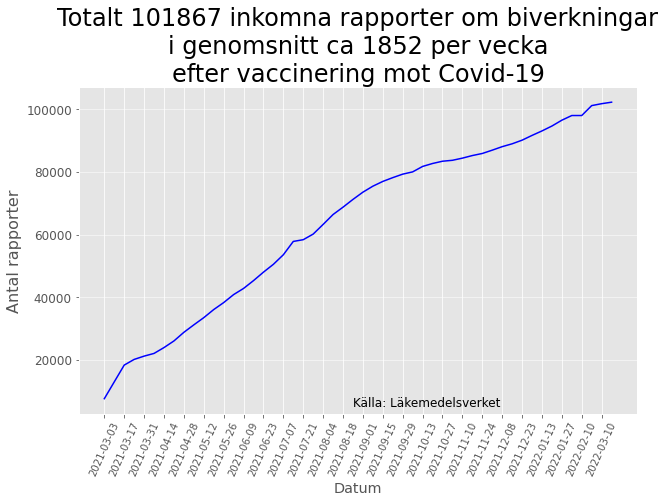

In [15]:
def plot_inkomna(df):
    plt.style.use('ggplot')
    # df.date = pd.to_datetime(df.date)
    df.okänd_spruta.fillna(0,inplace=True)
    df['tot'] = df['Ej handlagda']+df.Handlagda+df.okänd_spruta
    df.tot = df.tot.astype(int)
    # plot tot over time
    plt.figure(figsize=(10,6))
    plt.rcParams['font.size'] = 12
    plt.grid(axis='y', linestyle='-', linewidth=0.5)
    # caption  "Från LMV" under the graph on the right side
    plt.text(25, 5000, 'Källa: Läkemedelsverket',)
    
    plt.plot(df.date,df.tot,'-',color='blue',label='inkomna')
    #rotate x-axis labels 66 degrees
    plt.xticks(df.date[::2], rotation=66,fontsize=10, fontweight='light')
    
    antal_veckor = 52-9+week
    snitt_per_vecka = int(round(SUMMA_RAPPORTER/antal_veckor))
    # in title set Totalt to bold
    plt.title(f'Totalt {SUMMA_RAPPORTER} inkomna rapporter om biverkningar\ni genomsnitt ca {snitt_per_vecka} per vecka\nefter vaccinering mot Covid-19',fontsize=24)

    plt.xlabel('Datum')
    plt.ylabel('Antal rapporter',fontsize=16)
    
    plt.savefig(f'1 antal inkomna rapporter {sista_datum} v{week}.jpg',dpi=300, bbox_inches='tight')
    
    plt.show()
# display(antal_handlagda)    
plot_inkomna(antal_handlagda)


## Graf med andel handlagda över tid

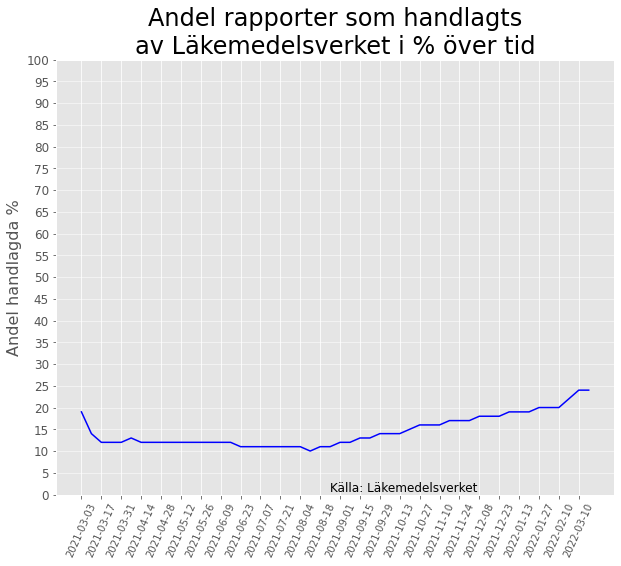

In [16]:
def plot_handlagda_över_tid(df):
    plt.style.use('ggplot')
    plt.figure(figsize=(10,8))
    # fontsize = 12
    plt.rcParams['font.size'] = 12
    # titel = 'Andel handlagda rapporter över tid'
    plt.title('Andel rapporter som handlagts\nav Läkemedelsverket i % över tid',fontsize=24)
    # yaxis max 50 
    plt.ylim(0,100)
    plt.yticks(np.arange(0,101,5))
    # yaxis grid
    plt.grid(axis='y', linestyle='-', linewidth=0.5)
    # yaxis label '%'
    plt.ylabel('Andel handlagda %',fontsize=16)
    # caption  "Från LMV" under the graph on the right side
    plt.text(25, 0.7, 'Källa: Läkemedelsverket',)
    # plt.xlabel('Datum')
    plt.plot(df.date,df.handlagt,'-',color='blue',label='handlagt')
    #rotate x-axis labels 66 degrees
    plt.xticks(df.date[::2], rotation=66,fontsize=10, fontweight='light')
    plt.savefig(f'3 handlagt över tid {sista_datum} v{week}.jpg',dpi=300, bbox_inches='tight')
   
    plt.show()
plot_handlagda_över_tid(antal_handlagda)

## Graf med allvarliga biverkningar

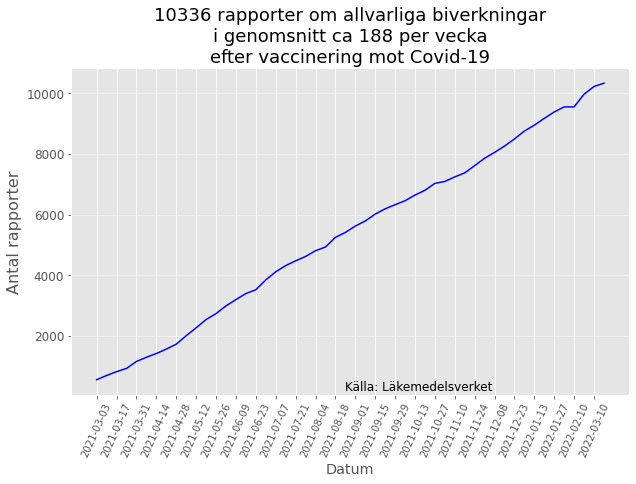

In [17]:
def plot_allvarliga(df):
    plt.style.use('ggplot')
    
    plt.figure(figsize=(10,6))
    plt.rcParams['font.size'] = 12
    plt.grid(axis='y', linestyle='-', linewidth=0.5)
    # caption  "Från LMV" under the graph on the right side
    plt.text(25, 200, 'Källa: Läkemedelsverket',)
    
    plt.plot(df.date,df.Allvarliga,'-',color='blue',label='allvarliga')
    #rotate x-axis labels 66 degrees
    plt.xticks(df.date[::2], rotation=66,fontsize=10, fontweight='light')
    
    antal_veckor = 52-9+week
    snitt_per_vecka = int(round(df.Allvarliga.iloc[-1]/antal_veckor))
    plt.title(f'{df.Allvarliga.iloc[-1]} rapporter om allvarliga biverkningar\ni genomsnitt ca {snitt_per_vecka} per vecka\nefter vaccinering mot Covid-19',fontsize=18)

    plt.xlabel('Datum')
    plt.ylabel('Antal rapporter',fontsize=16)
    
    plt.savefig(f'4 antal allvarliga rapporter {sista_datum} v{week}.jpg',dpi=300, bbox_inches='tight')
    
    plt.show()
# display(antal_handlagda)    
plot_allvarliga(antal_handlagda)

## Pie graf med andel handlagda

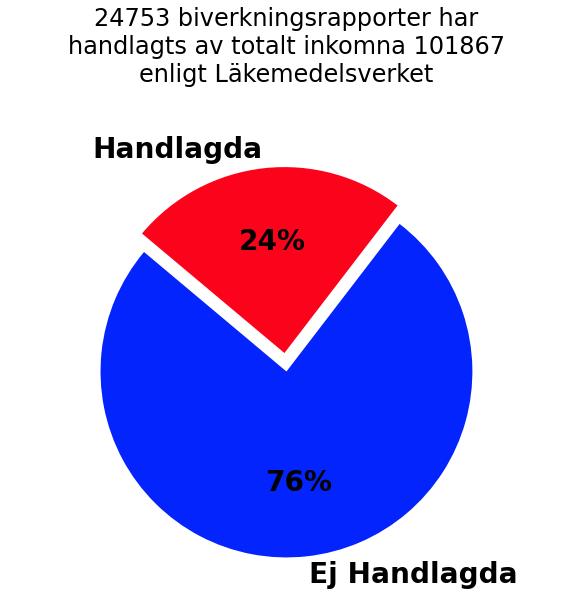

In [18]:
# make a pie diagram for SUMMA_HANDLAGDA and SUMMA_RAPPORTER
def pie():
    labels = 'Ej Handlagda', 'Handlagda'
    sizes = [SUMMA_RAPPORTER-SUMMA_HANDLAGDA, SUMMA_HANDLAGDA]
    colors = ['#0324fc', '#fc031c', 'white']
    explode = (0.1, 0)  # explode 1st slice
    # make pie bigger
    plt.rcParams['font.size'] = 28
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['text.color'] = 'black'
    # make figure bigger    
    plt.figure(figsize=(10,8))
    # make background color white
    # plt.rcParams['patch.facecolor'] = 'white'
    
    proc_handlagda = int(round(100*SUMMA_HANDLAGDA/SUMMA_RAPPORTER))
    # plt.suptitle(f'(efter {proc_handlagda}% handlagda rapporter)',fontsize=18)
    plt.title(f'{SUMMA_HANDLAGDA} biverkningsrapporter har\nhandlagts av totalt inkomna {SUMMA_RAPPORTER}\nenligt Läkemedelsverket\n\n', fontsize=24)

    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.f%%', shadow=False, startangle=140)
    plt.axis('equal')
    plt.savefig(f'2 Pie andel handlagda {sista_datum} v{week}.jpg',dpi=300, bbox_inches='tight')

    plt.show()
pie()    

## Grafer med döda över tid

In [19]:
numeriska=alla_döda.columns[2:12]
df = alla_döda.copy()
df['Total'] = alla_döda[numeriska].sum(axis=1)
kvinns=df.loc[df.Kön=='kvinnor','Total'].iloc[-1]
gubbs=df.loc[df.Kön=='män','Total'].iloc[-1]
kvinns,gubbs,kvinns+gubbs

(196.0, 187.0, 383.0)

51 51


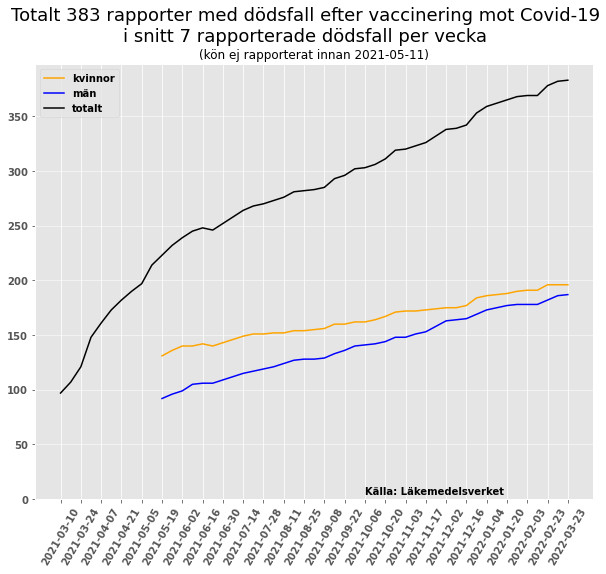

51 51


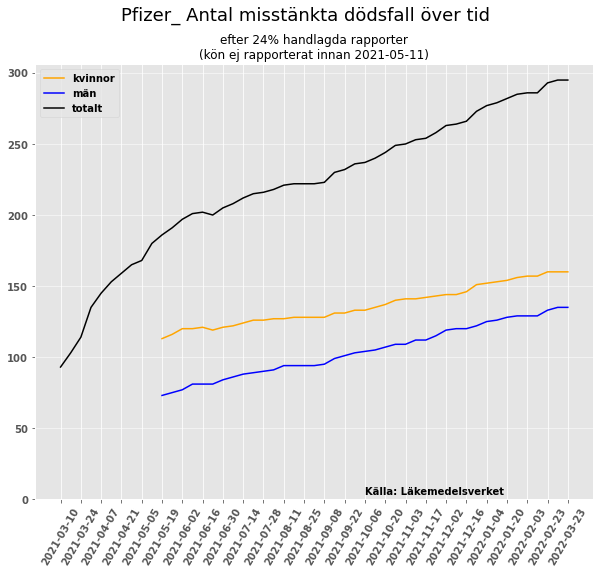

51 51


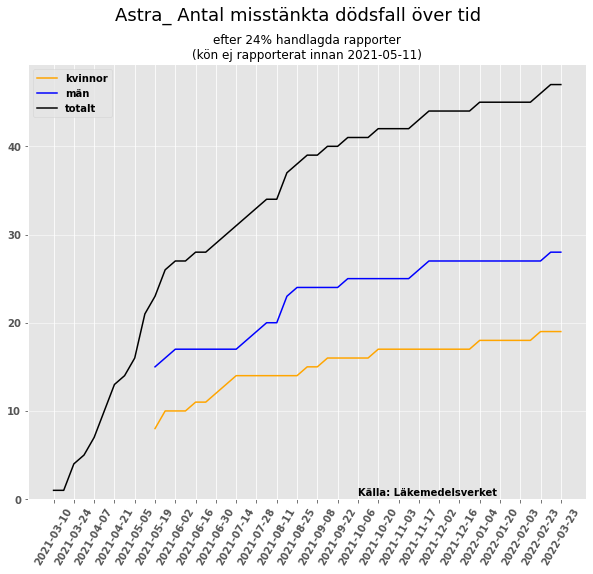

51 51


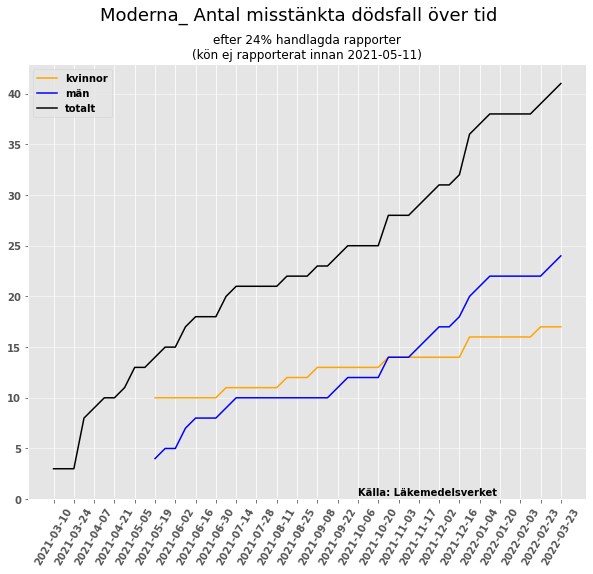

In [23]:
def graf_döda_över_tid(företag, tab_döda, graf_nr='', extra_text=False):
    # set index to datum
    # tab_döda.set_index('Datum',inplace=True)
    plt.style.use('ggplot')
    numeriska=tab_döda.columns[2:12]
    # tab_döda[numeriska] = tab_döda[numeriska].astype(int)
    # display(tab_döda.describe())
    tab_döda['Total'] = tab_döda[numeriska].sum(axis=1)
    tab_döda.loc[tab_döda.Total==0.0,'Total'] = None
    
    döda_kvinnor = tab_döda[tab_döda.Kön=='kvinnor']
    döda_män = tab_döda[tab_döda.Kön=='män']
    döda_ej_kön = tab_döda[tab_döda.Kön=='okänt kön']
    fig=plt.figure(figsize=(10,8))
    andel_handlagda = round(100*SUMMA_HANDLAGDA/SUMMA_RAPPORTER)
    if extra_text:
        kvinns=df.loc[tab_döda.Kön=='kvinnor','Total'].iloc[-1]
        gubbs=df.loc[tab_döda.Kön=='män','Total'].iloc[-1]
        snitt = round((kvinns+gubbs)/antal_veckor)
        plt.suptitle(f'{företag} {int(kvinns+gubbs)} rapporter med dödsfall efter vaccinering mot Covid-19\ni snitt {snitt} rapporterade dödsfall per vecka',fontsize=18)
        plt.title(f'(kön ej rapporterat innan 2021-05-11)',fontsize=12)
    else:
        plt.suptitle(f'{företag} Antal misstänkta dödsfall över tid',fontsize=18)  
        plt.title(f'efter {andel_handlagda}% handlagda rapporter\n(kön ej rapporterat innan 2021-05-11)',fontsize=12)
    
    
    # axes = fig.add_axes([0.1,0.1,0.9,0.9])
    plt.plot(döda_kvinnor.Datum, döda_kvinnor.Total,'-', color='orange',label='kvinnor')
    plt.plot(döda_män.Datum, döda_män.Total,'b-',label='män')
    print(len(döda_män.Total),len(döda_kvinnor.Total))
    # plt.plot(döda_kvinnor.Datum, döda_ej_kön.Total,'r.-',label='okänt kön')
    
    döda_totalt = döda_kvinnor.Total.fillna(0).to_numpy()+döda_män.Total.fillna(0).to_numpy()+döda_ej_kön.Total.fillna(0).to_numpy()
    posupp = döda_totalt.max()/100
    plt.text(30, posupp, 'Källa: Läkemedelsverket',)

    plt.plot(döda_kvinnor.Datum,döda_totalt,'k-',label='totalt')
    plt.xticks(döda_kvinnor.Datum[::2],rotation=60)
    # display('kvinnor',döda_kvinnor[['Datum','Total']].iloc[-3:],'män',döda_män[['Datum','Total']].iloc[-3:],'ej kön',döda_ej_kön[['Datum','Total']].iloc[-3:])
    # display('totalt',döda_kvinnor[['Total']].iloc[-1]+döda_män[['Total']].iloc[-1]+döda_ej_kön[['Total']].fillna(0).iloc[-1])
    plt.legend()
    plt.ylim(ymin=0)
    plt.grid(axis='y', linestyle='-', linewidth=0.5)

    plt.savefig(f'{graf_nr} {företag}_döda_över_tid {sista_datum} v{week}.jpg')
    plt.show()
    
graf_döda_över_tid('Totalt', alla_döda, graf_nr=5, extra_text=True)   
graf_döda_över_tid('Pfizer_', pfizer_döda,graf_nr=8)    
graf_döda_över_tid('Astra_', astra_döda,graf_nr=8)  
graf_döda_över_tid('Moderna_', moderna_döda,graf_nr=8) 


## Graf med döda per åldersgrupp

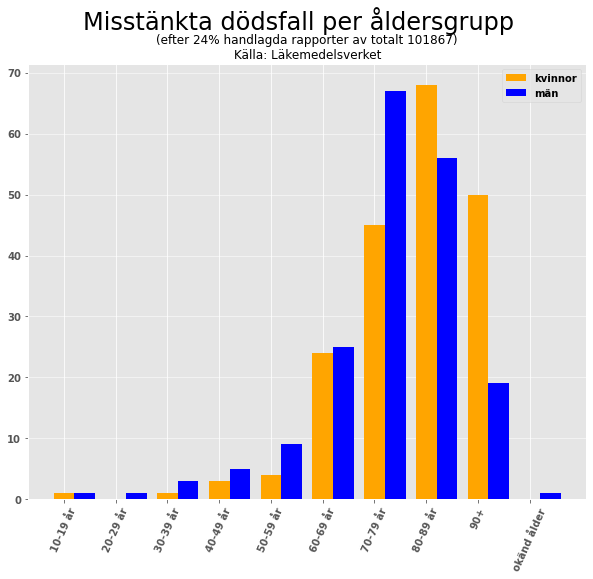

In [24]:
# plot bar for numeriska for Dataum = 2021-05-11

def komprimera_åldrar(df_,last_datum,antal_grupper):
    df=df_[df_.Datum==last_datum]
    
    df = df[numeriska]
    kolumner = list(df.columns)
    tot=0
    for kol in kolumner[:antal_grupper]:
        tot += df[kol].values
    df.drop(kolumner[:antal_grupper-1],inplace=True,axis=1)
    df.columns=['10-19 år']+kolumner[antal_grupper:]
    df['10-19 år'] = pd.Series(tot).values
    return df

def graf_döda(företag, df, numeriska):
    last_datum = df.iloc[-1].Datum
    # display(df)
    df = komprimera_åldrar(df,last_datum,1)
    # display(df)
    fig=plt.figure(figsize=(10,8))
    
    spc = np.arange(len(df.columns))
    plt.bar(spc,df.iloc[0].values,color='orange',label='kvinnor',width=0.4)
    # plt.text(0.5, 0.7, 'Källa: Läkemedelsverket',)
    
    plt.bar(spc+0.4,df.iloc[1].values,color='b',label='män',width=0.4)
    plt.xticks(spc,['10-19 år','20-29 år','30-39 år','40-49 år','50-59 år','60-69 år','70-79 år', '80-89 år','90+','okänd ålder'],rotation=66)
    plt.legend()
    andel_handlagda = round(100*SUMMA_HANDLAGDA/SUMMA_RAPPORTER)
    plt.title(f'(efter {andel_handlagda}% handlagda rapporter av totalt {SUMMA_RAPPORTER})\nKälla: Läkemedelsverket',fontsize=12)
    plt.suptitle(f'Misstänkta dödsfall per åldersgrupp',fontsize=24)
    plt.grid(axis='y', linestyle='-', linewidth=0.5)
    
    plt.savefig(f'6 misstänkta_dödsfall_per_åldersgrupp {sista_datum} v{week}.jpg')
    plt.show()
    
    
graf_döda('Alla', alla_döda, numeriska)

# Tester

In [25]:
# Komplettera saknade Allvarliga i antal_handlagda
# allvarliga_astra = pd.read_csv('allvarliga_astra.csv',header=None)
# allvarliga_astra.columns=['Datum','week','handlagt','Ej handlagda','Handlagda','okänd_spruta','Allvarliga']
# allvarliga_pfizer = pd.read_csv('allvarliga_pfizer.csv',header=None)
# allvarliga_pfizer.columns=['Datum','week','handlagt','Ej handlagda','Handlagda','okänd_spruta','Allvarliga']
# allvarliga_moderna = pd.read_csv('allvarliga_moderna.csv',header=None)
# allvarliga_moderna.columns=['Datum','week','handlagt','Ej handlagda','Handlagda','okänd_spruta','Allvarliga']
# allvarliga = allvarliga_astra[['Datum','Allvarliga']].copy()
# allvarliga.Allvarliga = allvarliga.Allvarliga + allvarliga_pfizer.Allvarliga + allvarliga_moderna.Allvarliga
# display(allvarliga)
# # läs in antalallvarliga2.csv no headers
# antal_handlagda2 = pd.read_csv('antal_handlagda2.csv')
# # för alla antal_handlagda2.date >= 2021-10-20 sätt 'Allvarliga' till allvsaliga.Allvarliga
# antal_handlagda2.loc[antal_handlagda2.date >= '2021-10-20','Allvarliga'] = allvarliga.Allvarliga.values
# antal_handlagda2.Allvarliga = antal_handlagda2.Allvarliga.astype(int)
# # antal_handlagda2.to_csv('antal_handlagda.csv',index=False)
